## Project: Knowledge Based Recommendation System
### Exploratory Data Analysis

#### DSC 630

Taniya Adhikari 15/24/2021

In [1]:
from bs4 import BeautifulSoup as BS
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
import seaborn as sns
import requests

import warnings; warnings.simplefilter('ignore')

import re
from re import sub
import multiprocessing
from unidecode import unidecode

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors


from time import time 
from collections import defaultdict

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
import textblob

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from sklearn.cluster import KMeans

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bibek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Dataset 1: Product List and Description

In [2]:
productList_df = pd.read_csv("prod_descR.csv", index_col=0)

In [3]:
productList_df.head(3)

,product_id,product_name,product_brand,price,product_type,product_description,description_clean
0,6562638659653,VITALIFT-A,Dr. Different,42.0,Other/Spot Treatments,this nighttime skin treatment is ideal for tho...,nighttime skin treatment ideal look improve ap...
1,6562639675461,VITALIFT-A Forte,Dr. Different,52.0,Other/Spot Treatments,those that need an extra boost to smooth out f...,need extra boost smooth fine line wrinkle real...
2,6562640429125,VITALIFT-A Eye & Neck,Dr. Different,40.0,Eye Treatment,for those looking to target fine lines and wri...,look target fine line wrinkle specifically aro...


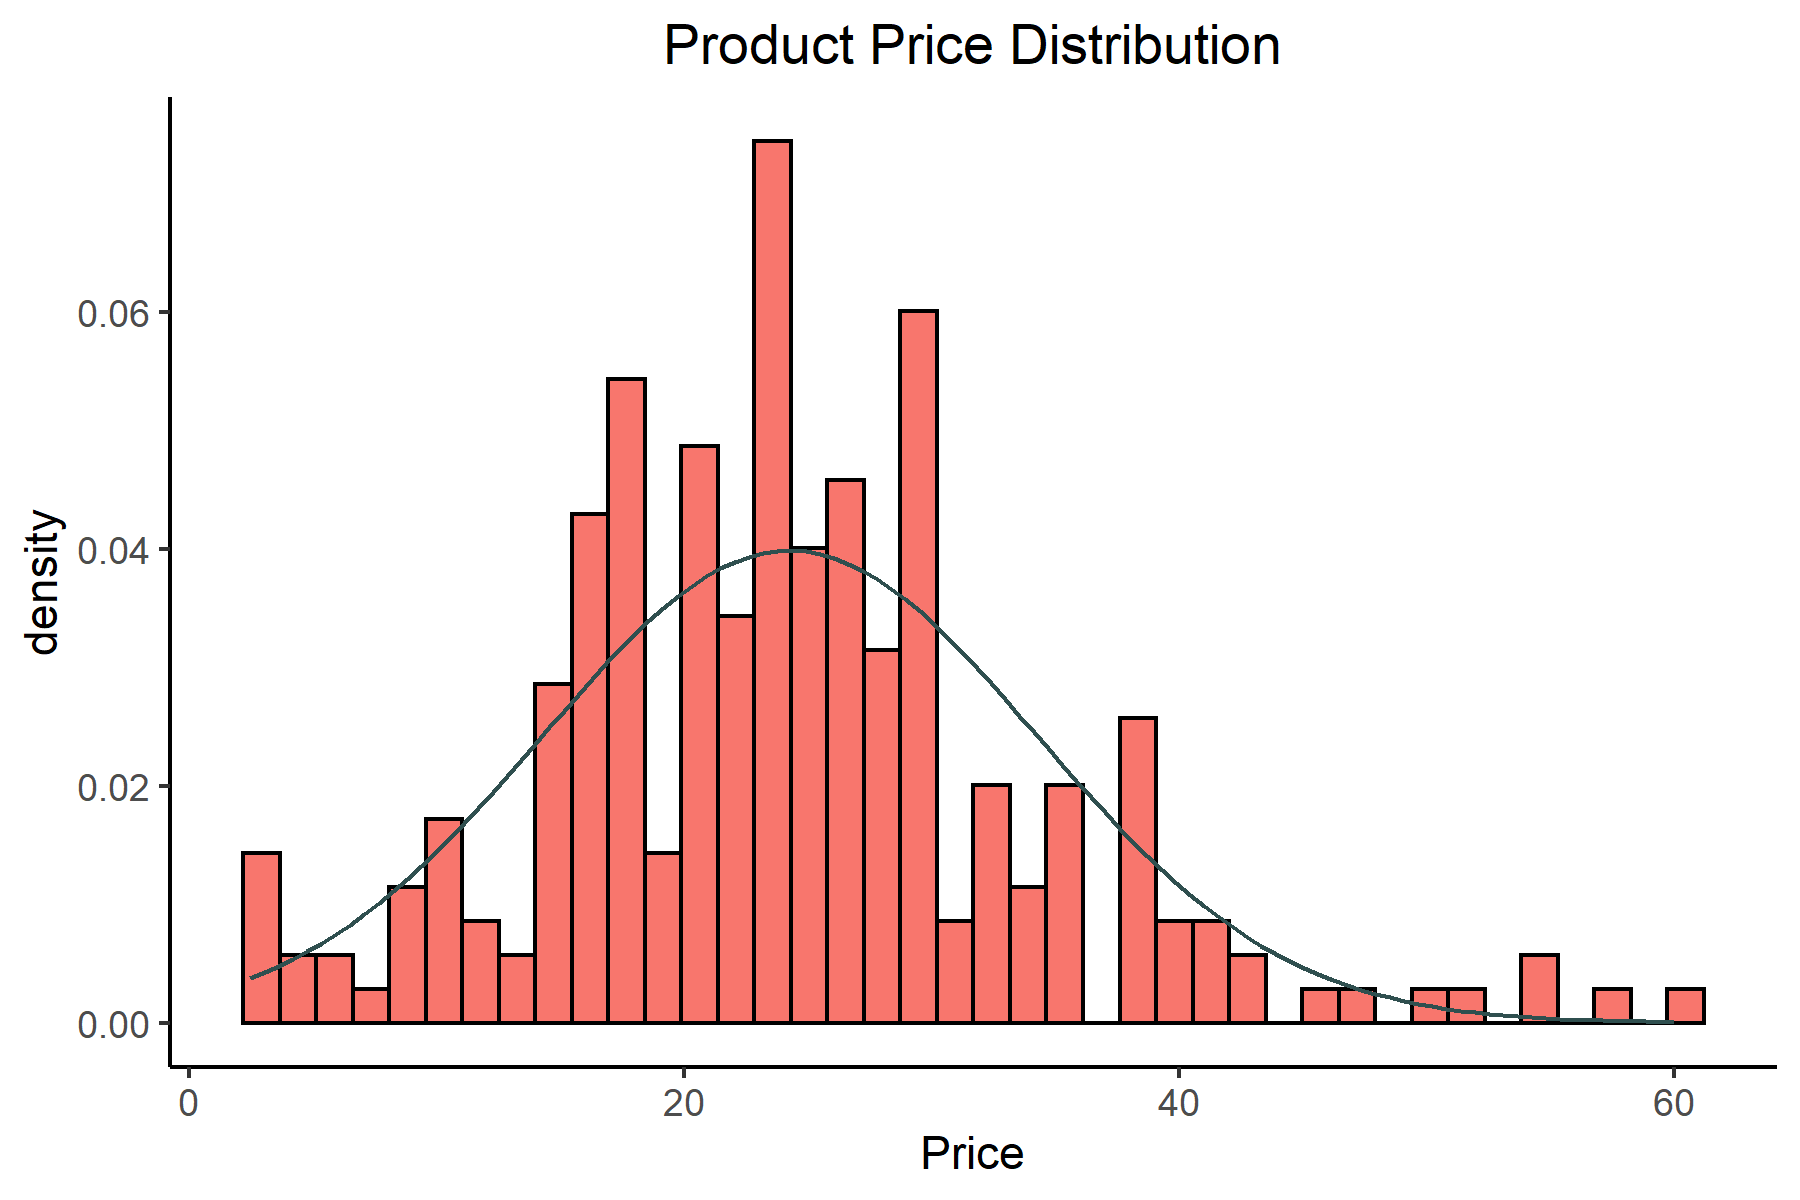

In [4]:
from IPython.display import Image
Image(filename='histogram_price.png')

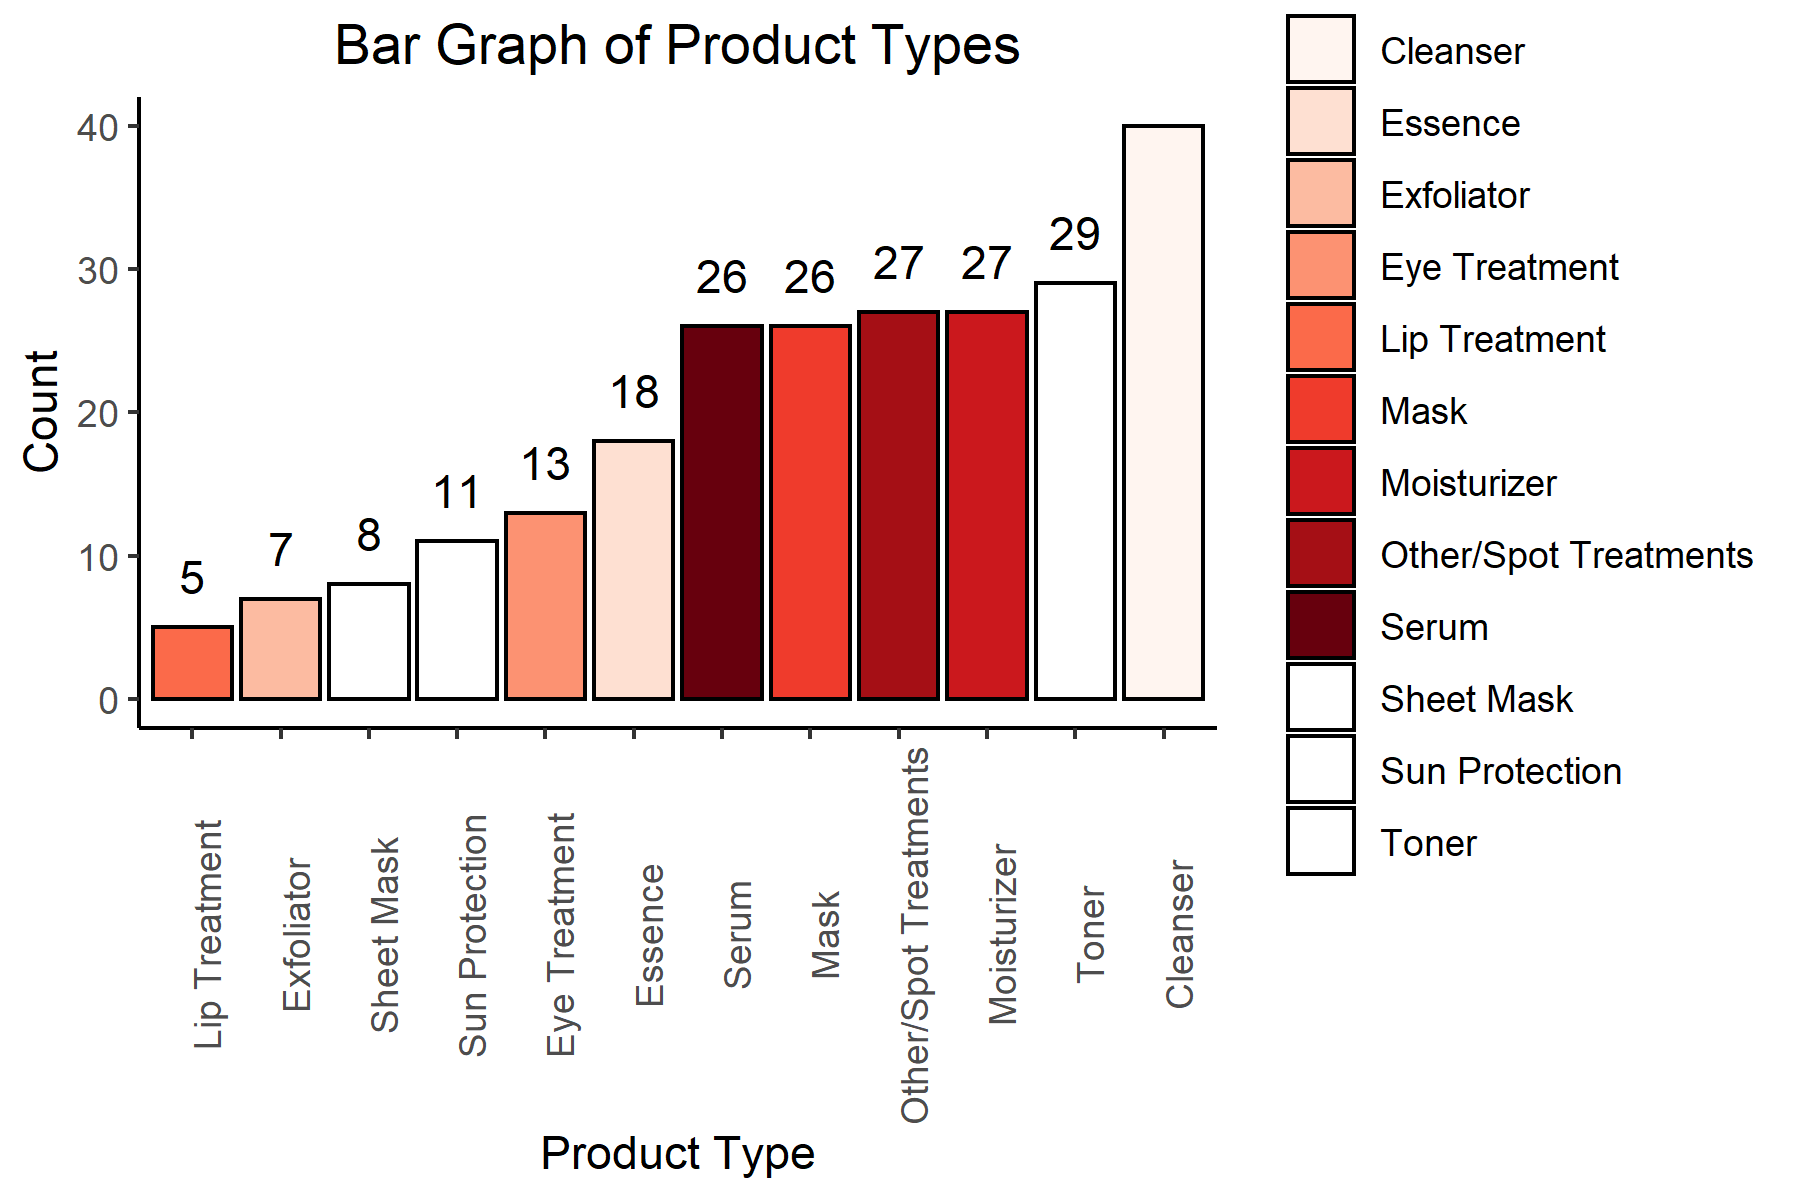

In [5]:
from IPython.display import Image
Image(filename='Bar_productType.png')

#### Dataset 2: Product Reviews

In [6]:
productReviews_df = pd.read_csv('clean_reviews.csv', index_col=0).dropna()
productReviews_df.head(3)

INFO - 04:49:23: NumExpr defaulting to 8 threads.


,product_id,review_sentiment,review_similarity,pos_tags,wordnet_pos,lemmatized
0,4669755719749,this makes my skin smooth and soft and is ligh...,make skin smooth soft lightweight absorbs quickly,"[('makes', 'VBZ'), ('skin', 'JJ'), ('smooth', ...","[('makes', 'v'), ('skin', 'a'), ('smooth', 'a'...","['make', 'skin', 'smooth', 'soft', 'lightweigh..."
1,4669755719749,love the silky texture its very lightweight bu...,love silky texture lightweight hydrate leaf sk...,"[('love', 'VB'), ('silky', 'JJ'), ('texture', ...","[('love', 'v'), ('silky', 'a'), ('texture', 'n...","['love', 'silky', 'texture', 'lightweight', 'h..."
2,4669755719749,i ve been trying to find a moisturizer that wo...,try find moisturizer would dry skin month espe...,"[('trying', 'VBG'), ('find', 'NN'), ('moisturi...","[('trying', 'v'), ('find', 'n'), ('moisturizer...","['try', 'find', 'moisturizer', 'would', 'dry',..."


In [7]:
productReviews_df.shape

(14548, 6)

In [8]:
productReviews_df= productReviews_df.reset_index(drop = True)

#### Fake review detection

Most common words

In [9]:
from collections import Counter

aggregate_counter = Counter()
for row_index,row in productReviews_df.iterrows():
    c = Counter(row['review_similarity'].split())
    aggregate_counter += c

common_words = [word[0] for word in aggregate_counter.most_common()]
common_words_counts = [word[1] for word in aggregate_counter.most_common()]

In [10]:
common_word = pd.DataFrame(list(zip(common_words, common_words_counts)),columns =['Word', 'Freq'])
common_word.to_csv('common_word.csv')

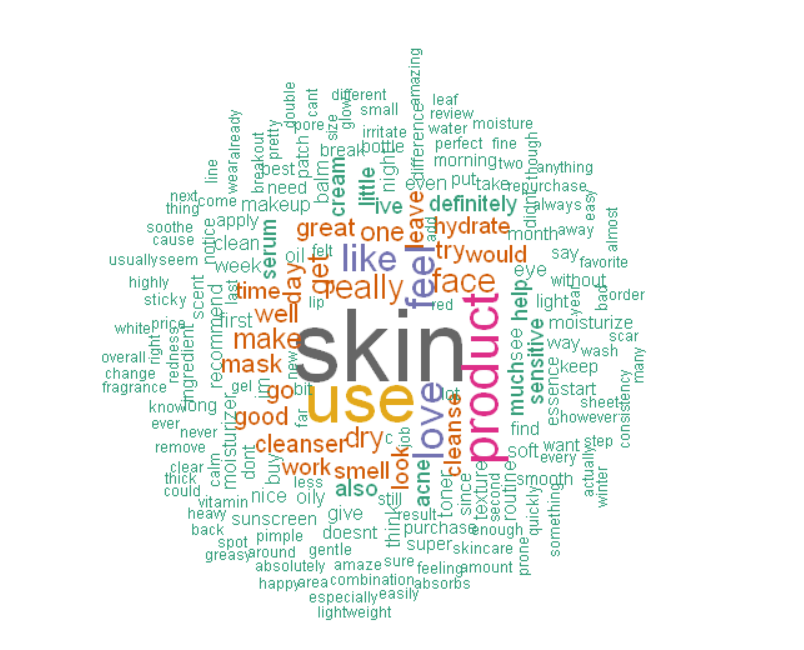

In [11]:
Image(filename='Most_Frequent_word.png')

No word Embeddings because we are not trying to find the contextual meaning

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Create array with each text
data_arr = np.array(productReviews_df['review_similarity'].values.astype("U"))

# Create the tf-idf feature matrix
tfidf = TfidfVectorizer()
feature = tfidf.fit_transform(data_arr)

# Show feature matrix
feature

<14548x10744 sparse matrix of type '<class 'numpy.float64'>'
	with 322688 stored elements in Compressed Sparse Row format>

In [13]:
#create dataframe
X=pd.DataFrame(feature.toarray())
tfidf2 = X.values.tolist()

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(feature)
Y=pd.DataFrame(cosine_sim)

#### Checking if there is any similar reviews

In [15]:
for col in Y.columns:
    if any(Y[col] > 80):
        print("True")       

In [16]:
from sklearn.feature_extraction.text import CountVectorizer


features = productReviews_df["review_similarity"].tolist() 
CountVec = CountVectorizer()
#transform
Count_data = CountVec.fit_transform(features)
Count_data

<14548x10744 sparse matrix of type '<class 'numpy.int64'>'
	with 322688 stored elements in Compressed Sparse Row format>

In [17]:
#create dataframe
cv_dataframe=pd.DataFrame(Count_data.toarray(),columns=CountVec.get_feature_names())

In [23]:
X = cv_dataframe[['acne', 'moisturizer', 'aging', 'dehydration', 'hydration', 'cleanser']]
X.head(5)

,acne,moisturizer,aging,dehydration,hydration,cleanser
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,1,0,0,0,0


In [21]:
df_merged = productReviews_df.merge(cv_dataframe, how='inner', left_index=True, right_index=True)

In [23]:
df_merged.to_csv('reviews_preprocess.csv')

In [31]:
Skin_Concern = ["acne", "aging", "dehydration","clogged pores", "hyper pigmentation", "sensitive", "redness", "uneven skintone", "dryness"]
Product_Type = ["Cleanser", "Mask", "Toner", "Moisturizer","Serum","Other/Spot Treatments","Essence",
                "Sheet Mask","Eye Treatment","Sun Protection","Exfoliator","Lip Treatment"]
Skin_Type = ["oily", "dry", "combination", "normal"]
Price_Range = ["$0-$20", "$21-$40", "$41-$60", "$61-$80"]
Skin_Goals = ["unclogged pores", "minimize pores", "reduce wrinkles", "remove blackheads", "remove dark spots", 
              "improve skin texture","reduce pigmentation", "soft skin", "hydration", "detox", "smooth skin", 
              "skin brighten","skin glow", "improve complexion", 'clear skin']